### Setup

#### Install requirements

In [41]:
%pip install -q -U -r https://raw.githubusercontent.com/MatteoFalcioni/Learning-LangGraph/main/requirements.txt

Note: you may need to restart the kernel to use updated packages.


#### local (notebooks or files)

In [42]:
from dotenv import load_dotenv
load_dotenv()  # load api keys

True

#### Colab

In [43]:
from google.colab import userdata
import os

REQUIRED_KEYS = [
    'OPENAI_API_KEY',
    'LANGSMITH_TRACING',
    'LANGSMITH_ENDPOINT',
    'LANGSMITH_API_KEY',
    'LANGSMITH_PROJECT',
    'TAVILY_API_KEY'
]

def _set_colab_keys(key : str):
    # Retrieve the secret value using its key/name
    secret_value = userdata.get(key)
    # set it as a standard OS environment variable
    os.environ[key] = secret_value

for key in REQUIRED_KEYS:
    _set_colab_keys(key)

ModuleNotFoundError: No module named 'google.colab'

# Agentic Graph - A Real Example 

Now we will make a more 'real application' implementation: we want to create a graph composed of two agents: one that searches data online and one that visualizes this data by executing Python code.

We will use both reducers and Command concepts.

To search online we will use the `Tavily` API. 

### Search Tool

We will give the `researcher` the premade [TavilySearch](https://docs.langchain.com/oss/python/integrations/tools/tavily_search#overview) tool.

Notice how we will extremely simplify the tool for the agent to use: we do not instruct it on anything that the Tavily API does, we mask all internal machinery.

In [56]:
from langchain_tavily import TavilySearch

# Define search tool
search_tool = TavilySearch(
  max_results=5,
  topic='general'
)

### Coding Tool

We will use [E2B](https://docs.langchain.com/oss/python/integrations/tools/e2b_data_analysis) in order to execute code in a sandboxed environment. Get your E2B api key [here](https://e2b.dev/docs/api-key). 

In [57]:
from langchain.tools import tool, ToolRuntime
from e2b_code_interpreter import Sandbox
from langgraph.types import Command
from typing_extensions import Annotated
from langchain_core.messages import ToolMessage

# create a sandbox for the whole run 
sbx = Sandbox.create(timeout=600) # By default the sandbox is alive for 5 minutes

@tool
def python_interpreter(code: Annotated[str, "The Python code to execute"], runtime: ToolRuntime) -> Command:
    """
    Executes Python code in a sandboxed environment. 
    Use this to run data analysis, generate charts, or execute python scripts.
    """

    execution = sbx.run_code(code) # Execute Python inside the sandbox
    
    logs = execution.logs

    out = logs.stdout[-1] if len(logs.stdout) > 0 else ""
    err = logs.stderr[-1] if len(logs.stderr) > 0 else ""

    return Command(
        update={
            "messages" : [ToolMessage(content=f"stdout: \n```python{out}\n```\nstd err: \n```python{err}\n```", tool_call_id=runtime.tool_call_id)],
            "code_logs" : [
                {
                    "input" : code,
                    "output" : {
                        "stdout" : out,
                        "stderr" : err 
                    }
                }
            ]
        }
    )

# Download file from the sandbox by absolute path '/home/user/{filename}'
@tool 
def download_image(filename: Annotated[str, "the file name, included its extension"], runtime: ToolRuntime) -> Command:
    """
    Use this to download a visualization from the sandbox to the user's machine.
    """
    content = sbx.files.read(path=f'/home/user/{filename}', format='bytes')

    output_path = f'./6_agentic_graph/downloads/{filename}'

    with open(output_path, 'wb') as file:
        file.write(content)

    return Command(
        update={
            "messages": [
                    ToolMessage(
                        content=f"File '{filename}' downloaded successfully to {output_path}",
                        tool_call_id=runtime.tool_call_id
                )
            ]
        }
    )

    

### State and Reducers

In [58]:
from langchain.agents import AgentState

# Define reducer
def add_list(left: list | None, right: list | None) -> list:
    """
    Reducer to combine lists. 
    If left is not None and right is empty, resets the list.
    """
    if left is None:
        left = []
    if right is None:
        right = []

    if left is not None and len(right) == 0:  # i.e., we pass an empty list [] as update
        return [] # cleans list

    return left + right

# Define graph state
class MyState(AgentState):
    code_logs : Annotated[list[dict], add_list]

### Instantiate the Agents

In [59]:
from langchain.agents import create_agent
from langchain_openai import ChatOpenAI

# instantiate the research agent
research_prompt = """
You are an agent specialized in online research. You can use your search tool to search online.
You work with a coder colleague that will provide the data you need to visualize.

You will be asked to search for information about a specific topic online and produce a visualization of the data.
You will need to use the `search_tool` to search online and then provide the data to the coder colleague.

To provide the data to the coder colleague, you MUST answer with a message containing the data you found, with the prefix 'DATA:'.
"""

research_agent = create_agent(
    model=ChatOpenAI(model="gpt-4o", temperature=0),
    system_prompt=research_prompt,
    tools=[search_tool],  
    state_schema=MyState,  # (!!!) notice we are passing our state here
)

In [60]:
coder_prompt="""
You are an agent specialized in visualizing data by executing Python code.
You work with a researcher colleague that will provide the data you need to visualize. 

## Tools

In order to write Python code to produce visualizations and then show them to the user, you can use the following tools:

- `python_interpreter(code)` tool: runs the given code in a sandboxed environment. Use this to produce a visualization of the data. 
- `download_image(filename)` tool: downloads the given file from the sandbox to the user's machine. Use this to download the visualization, so that it can be shown to the user.

# CRITICAL INSTRUCTIONS

- When producing an image, you MUST save the image as .png format. 
"""

In [61]:
# instantiate the coder agent

coder_agent = create_agent(
    model=ChatOpenAI(model="gpt-4.1", temperature=0),
    system_prompt=coder_prompt,
    tools=[python_interpreter, download_image],  
    state_schema=MyState,  
)

### Nodes

node description...

In [62]:
from typing_extensions import Literal
from langgraph.types import Command
from langchain_core.messages import HumanMessage, AIMessage

# Define the nodes
def research_node(state: MyState) -> Command[Literal["coder"]]:
    print("---research node---")
    result = research_agent.invoke(state)
    last_msg = result['messages'][-1]

    # note how Command allows you to BOTH update the graph state AND route to the next node
    return Command(
        update={
            "messages": [AIMessage(content=last_msg.content)],   # wrap in HumanMessage to avoid problems (some providers do not allow AIMessage as last message)
        },
        goto="coder",
    )

def coder_node(state: MyState) -> Command[Literal["__end__"]]:
    print("---coder node---")
    
    result = coder_agent.invoke(state)
    last_msg = result['messages'][-1]
    logs = result['code_logs']  # it's a list of dicts, each containing the input and output of the code execution

    return Command(
        update={
            "messages": [AIMessage(content=last_msg.content)],
            "code_logs": logs,  # reducer takes list so it's fine
        },
        goto="__end__"
    )

### Construct the Graph

Let's build the graph

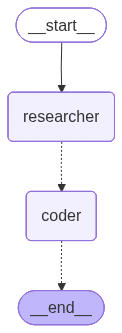

In [63]:
from langgraph.graph import StateGraph, START

builder = StateGraph(MyState)
builder.add_node("researcher", research_node)
builder.add_node("coder", coder_node)
builder.add_edge(START, "researcher")
# notice how we do not need to specify edges between nodes since we are using Command

graph = builder.compile()

from IPython.display import display, Image  
display(Image(graph.get_graph().draw_mermaid_png()))

### Invoke the Graph

In [64]:
init_state = {"messages" : [HumanMessage(content="Produce a visualization of the data about inflation in Argentina in the last 10 years.")]}

result = graph.invoke(init_state)

---research node---
---coder node---


In [65]:
for messages in result['messages']:
    messages.pretty_print()

================================ Human Message =================================

Produce a visualization of the data about inflation in Argentina in the last 10 years.
================================== Ai Message ==================================

DATA:

Here is the data on Argentina's inflation rate over the last 10 years:

- 2024: 219.89%
- 2023: 133.49%
- 2022: 72.43%
- 2021: 48.41%
- 2020: 42.02%
- 2019: 53.55%
- 2018: 34.28%
- 2017: 25.68%
- 2016: 26.50%
- 2015: Data not explicitly available in the search results
- 2014: Data not explicitly available in the search results
- 2013: 10.62%

This data is sourced from Statista and Trading Economics, with additional context from World Data Info. The inflation rates show a significant increase in recent years, particularly in 2024.
================================== Ai Message ==================================

The visualization of Argentina's inflation rate over the last 10 years has been created. You can now view or download the ch